In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import sklearn
import imblearn as imb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)
print("Python version:", os.sys.version)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Imbalanced-learn version:", imb.__version__)

TensorFlow version: 2.16.1
NumPy version: 1.26.4
OpenCV version: 4.9.0
Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
Pandas version: 2.2.2
Matplotlib version: 3.9.0
Scikit-learn version: 1.4.2
Imbalanced-learn version: 0.12.2


In [3]:
DATASET_PATH = '../dataset'
IMAGE_SIZE = (256, 256)

Functions

In [4]:
def load_image(image_path):
  try:
    image = cv2.imread(image_path)
    if image is None:
      raise FileNotFoundError("Failed to load image. Please check the file path.")
    return image
  except Exception as e:
    print("Error:", e)
    return None

In [5]:
def image_preprocessing(image):
  image = cv2.resize(image, IMAGE_SIZE)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  equalized = clahe.apply(gray)
  # equalized = equalized.astype(np.float32) / 255.0
  return image, gray, equalized

In [6]:
def show_image(image, title):
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.axis('off')
  plt.show()

Data Preprocessing

In [7]:
categories = []
images = []
grays = []
equalizeds = []
labels = []

for dir in os.listdir(path=DATASET_PATH):
    categories.append(dir)
    dir_path = os.path.join(DATASET_PATH, dir)

    for file in os.listdir(dir_path):
        file_path = os.path.join(DATASET_PATH, dir, file)
        image = load_image(file_path)

        if image is not None:
            image, gray, equalized = image_preprocessing(image)
            images.append(image)
            grays.append(gray)
            equalizeds.append(equalized)
            labels.append(categories.index(dir))

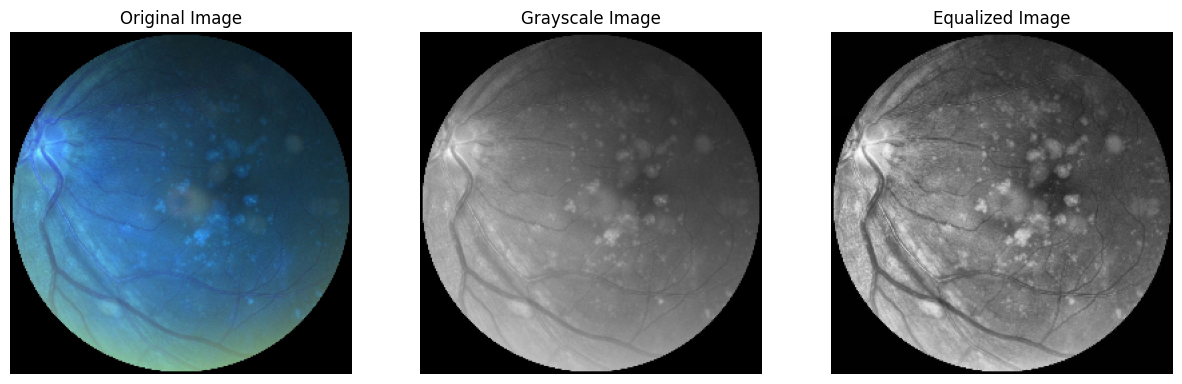

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grays[0], cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(equalizeds[0], cmap='gray')
plt.title('Equalized Image')
plt.axis('off')
plt.show()

In [9]:
x = np.array(equalizeds)
y = np.array(labels)
print("Data shape:", x.shape, y.shape)

Data shape: (4843, 256, 256) (4843,)


In [10]:
x_reshaped = x.reshape(x.shape[0], -1)
print("Reshaped data shape:", x_reshaped.shape)

Reshaped data shape: (4843, 65536)


In [11]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_reshaped, y)
print("Resampled data shape:", x_resampled.shape, y_resampled.shape)

Resampled data shape: (7686, 65536) (7686,)


In [12]:
x_resampled_reshaped = x_resampled.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1])
x_expanded = np.expand_dims(x_resampled_reshaped, axis=-1)
x_expanded = np.repeat(x_expanded, 3, axis=-1)
print("Resampled reshaped data shape:", x_expanded.shape)

Resampled reshaped data shape: (7686, 256, 256, 3)


In [13]:
downsampled_images = [cv2.resize(image, (64, 64)) for image in x_expanded]
x_normalized = np.array(downsampled_images).astype(np.float32) / 255.0


Data Visualization

In [14]:
def show_bar_chart(x_axis, y_axis, title, x_label, y_label):
  plt.figure(figsize=(8, 4))
  bars = plt.bar(x_axis, y_axis)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.ylim(0, 1200)
  for bar, value in zip(bars, y_axis):
      plt.text(bar.get_x() + bar.get_width() / 2, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)
  plt.show()

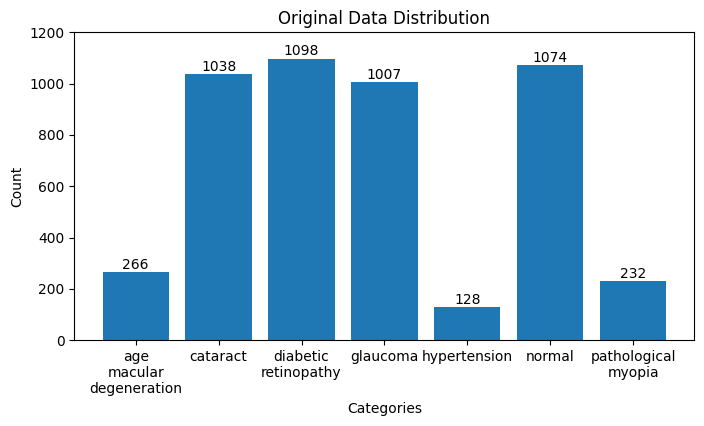

In [15]:
x_axis = [categories.replace('_', '\n') for categories in categories]
y_axis = [len(y[y == i]) for i in range(len(categories))]
show_bar_chart(x_axis, y_axis, 'Original Data Distribution', 'Categories', 'Count')

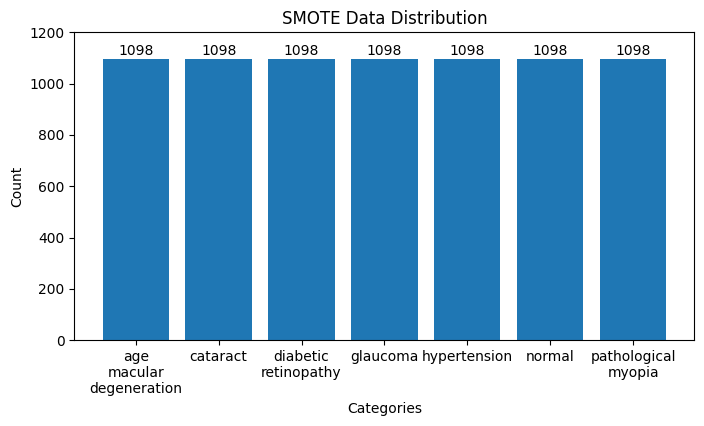

In [16]:
x_axis = [categories.replace('_', '\n') for categories in categories]
y_axis = [len(y_resampled[y_resampled == i]) for i in range(len(categories))]
show_bar_chart(x_axis, y_axis, 'SMOTE Data Distribution', 'Categories', 'Count')

Model VGG-19

In [47]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y_resampled, test_size=0.2, random_state=42)
print("Train data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Train data shape: (6148, 64, 64, 3) (6148,)
Test data shape: (1538, 64, 64, 3) (1538,)


In [19]:
vgg19_model = VGG19(
  include_top=False,
  weights=None,
  input_tensor=None,
  input_shape=(64, 64, 3),
  pooling=None,
  classes=1000,
  classifier_activation="softmax",
)

In [48]:
vgg19_model.trainable = False

x = vgg19_model.output
x = Flatten()(x)
x_shape = x.shape[1]

x_shape = int(x_shape / 2)
x = Dense(x_shape, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=vgg19_model.input, outputs=predictions, name='VGG19_Eye_Diseases_Classification')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
model.summary()

Model: "VGG19_Eye_Diseases_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             

 Total params: 22,129,735 (84.42 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [45]:
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.3866 - loss: 1.4419 - val_accuracy: 0.3706 - val_loss: 1.4400
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.3839 - loss: 1.4326 - val_accuracy: 0.4005 - val_loss: 1.4289
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 51s 263ms/step - accuracy: 0.3808 - loss: 1.4366 - val_accuracy: 0.3869 - val_loss: 1.4221
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.3899 - loss: 1.4319 - val_accuracy: 0.3836 - val_loss: 1.4198
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 253ms/step - accuracy: 0.4100 - loss: 1.4248 - val_accuracy: 0.4103 - val_loss: 1.4160
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 260ms/step - accuracy: 0.4103 - loss: 1.4034 - val_accuracy: 0.4161 - val_loss: 1.4110
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 50s 260ms/step - accuracy: 0.4251 - loss: 1.3928 - val_accuracy: 0.3823 - val_loss: 1.4035
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 47s 245ms/step - accuracy: 0.4204 - loss: 1

KeyboardInterrupt: 

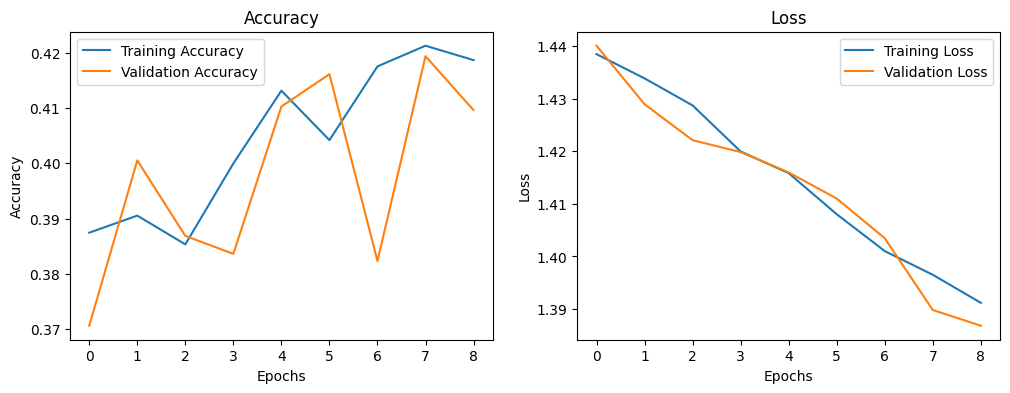

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
model.save(f'../trained_model/vgg19_model_{round(model.history.history['accuracy'][19] * 100, 2)}.h5')